Reading this paper [Deep Gaussian Process for Crop Yield Prediction Based on Remote Sensing Data](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14435) makes me very curious about Gaussian Process. It seems like a very powerful and flexible techniques. In this notebook, I will perform some simple illustrations of Gaussian process and explore how Gaussian process was used in the paper.
# Gaussian process tutorial

In [1]:
'''
Gaussian process tutorial
http://katbailey.github.io/post/gaussian-processes-for-dummies/
http://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py

''' 
import numpy as np
import matplotlib.pyplot as pl
from sklearn import metrics

# Define the kernel function
# Squared exponential function
def my_kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

At the core it's a kernel function that calculate the covariance between any two points

In [3]:
param = 0.1
K_ss = my_kernel(Xtest, Xtest, param)

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

print(K_ss.shape)
K_ss[:5, :5]

(50, 50)


array([[1.        , 0.8120068 , 0.43474907, 0.15347477, 0.03572355],
       [0.8120068 , 1.        , 0.8120068 , 0.43474907, 0.15347477],
       [0.43474907, 0.8120068 , 1.        , 0.8120068 , 0.43474907],
       [0.15347477, 0.43474907, 0.8120068 , 1.        , 0.8120068 ],
       [0.03572355, 0.15347477, 0.43474907, 0.8120068 , 1.        ]])

Note that K_ss is similar to a covariance matrix. The complicated function sqdit = np.sum... is so every element of K_ss will be of the form 
$$\kappa(x, x') = exp(-\frac{1}{2*l^2}(x-x')^2)=exp(-\frac{1}{2*l^2}(x^2-2xx'+x'^2))$$

We then procceed with Algorithm 15.1 [here](http://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf) <br>
$$\overline{f_\ast} = k_\ast^T K_y ^{-1} y$$
$$K_y = LL^T$$
$$\alpha = K_y ^{-1} y = L^{-T} L^{-1} y$$

so we can rewrite as:
$$L = cholesky(K + \sigma_y ^2 I)$$
$$\alpha = L^T / (L/y) $$
$$\overline{f_\ast} = k_\ast ^T \alpha$$
$$v = L /k_\ast$$

ie, once we have specified the covariance function, we have a deterministic formula for predictions based on linear algebra. This sounds just like multivariable Gaussian distribution.

Now that we have seen the kernel, let's see how it is fitted and predicted.

In [4]:
N = 10         # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.
np.random.seed(42)

f = lambda x: np.sin(0.9*x).flatten()

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = my_kernel(X, X, param)
L = np.linalg.cholesky(K + 10*s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

In [5]:
# compute the mean at our test points.
Lk = np.linalg.solve(L, my_kernel(X, Xtest, param))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = my_kernel(Xtest, Xtest, param)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

Based on the formula in the text on Gaussian Process (here)[www.gaussianprocess.org/gpml/chapters/RW.pdf], we have the explicit formula for the predictive mean and variance.

In [6]:
print(mu[:10])
print(s[:10])

[ 0.13729027  0.36475224  0.63891206  0.73747833  0.55884736  0.27021346
  0.06400068 -0.02708204 -0.04753517 -0.03509375]
[0.982727   0.87077868 0.50808834 0.10150173 0.65018541 0.89569956
 0.81294163 0.39813817 0.22697217 0.73127294]


[-5, 5, -3, 3]

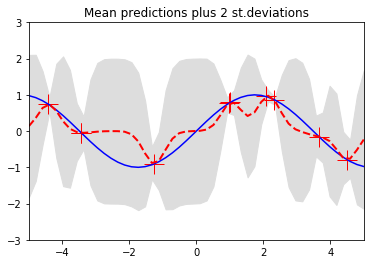

In [7]:
# PLOTS:
pl.plot(X, y, 'r+', ms=20)
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-2*s, mu+2*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 2 st.deviations')
pl.axis([-5, 5, -3, 3])

Because this is a Bayesian approach, we can sample from the prior and posterior distribution to see how they look like.

[-5, 5, -3, 3]

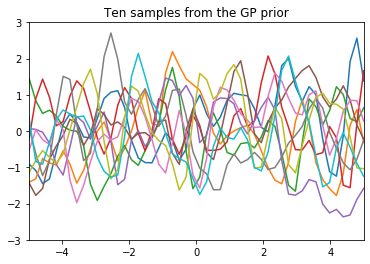

In [8]:
# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])

[-5, 5, -3, 3]

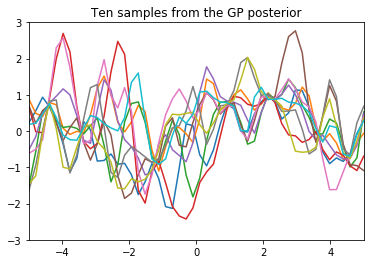

In [197]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])

# Sklearn
Let's see Gaussian Process Regressor from Sklearn

In [205]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel = RBF()
gaussian_regressor = GaussianProcessRegressor(kernel=kernel)
gaussian_regressor.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [206]:
fx, var = gaussian_regressor.predict(X, return_std=True)

C:\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


MSE for training: 3.8754860708e-12


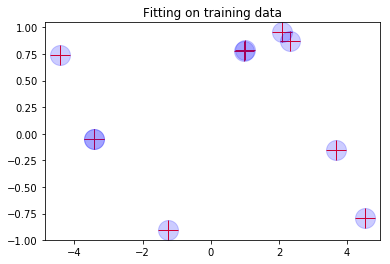

In [207]:
pl.plot(X, y, 'r+', ms=20)
pl.plot(X, fx, 'bo', alpha = 0.2, ms=20)
pl.title("Fitting on training data")
print("MSE for training:", metrics.mean_squared_error(y, fx))

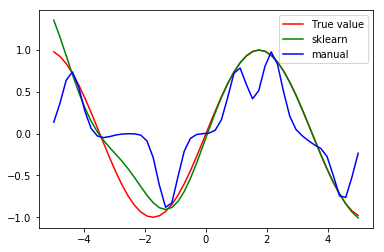

In [208]:
pl.plot(Xtest, f(Xtest),'r', label ='True value')
pl.plot(Xtest, gaussian_regressor.predict(Xtest, return_std=False),'g', label = 'sklearn')
pl.plot(Xtest, mu,'b', label = 'manual')
pl.legend()

In [209]:
y_sample = gaussian_regressor.sample_y(X,10)
samples = pd.DataFrame(np.hstack((X, y_sample)))
samples.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.254599,-0.904075,-0.904061,-0.904085,-0.904054,-0.904074,-0.904066,-0.904079,-0.904077,-0.904070,-0.904070
1,4.507143,-0.792417,-0.792425,-0.792434,-0.792450,-0.792430,-0.792442,-0.792452,-0.792444,-0.792441,-0.792421
2,2.319939,0.869225,0.869208,0.869195,0.869206,0.869209,0.869199,0.869201,0.869211,0.869195,0.869217
3,0.986585,0.775738,0.775739,0.775743,0.775737,0.775754,0.775746,0.775746,0.775744,0.775753,0.775740
4,-3.439814,-0.045722,-0.045732,-0.045719,-0.045735,-0.045748,-0.045739,-0.045745,-0.045740,-0.045713,-0.045730


In [210]:
# Sort so that we can plot it easily
samples = samples.sort_values(by=0)
samples.head()

,0,1,2,3,4,5,6,7,8,9,10
6,-4.419164,0.741666,0.741651,0.741669,0.741650,0.741650,0.741645,0.741650,0.741655,0.741638,0.741644
5,-3.440055,-0.045610,-0.045603,-0.045622,-0.045613,-0.045627,-0.045616,-0.045627,-0.045623,-0.045609,-0.045618
4,-3.439814,-0.045722,-0.045732,-0.045719,-0.045735,-0.045748,-0.045739,-0.045745,-0.045740,-0.045713,-0.045730
0,-1.254599,-0.904075,-0.904061,-0.904085,-0.904054,-0.904074,-0.904066,-0.904079,-0.904077,-0.904070,-0.904070
3,0.986585,0.775738,0.775739,0.775743,0.775737,0.775754,0.775746,0.775746,0.775744,0.775753,0.775740


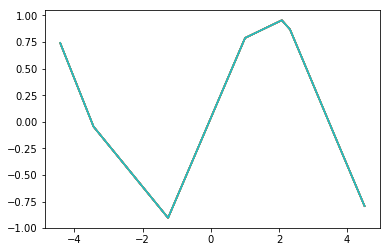

In [211]:
for i in range(10):
    pl.plot(samples.iloc[:,0], samples.iloc[:,i+1])

# How Gaussian process is used in the paper
The example above illustrates Gaussian Process with zero-mean:
$$f(x) \sim GP(0, \kappa (x, x'))$$
but the application is about a Gaussian process where the mean is dependent on the data:
$$g(x) = f(x) + h(x)^T\beta$$ where $$f(x) \sim GP(0, \kappa (x, x'))$$
$$\beta \sim N(b, B) $$
Fortunately, on page 29 of the textbook, we have an explicit formula for the solution. This is the exact formula that was implemented in the paper, but it took me some time to fully grasp it.

The formula in the textbook is:
$$\overline{g}(X_\ast) = H_\ast^T \overline{\beta} + K_\ast^T K_y^{-1}(y - H^T \overline{\beta}) $$
$$\overline{\beta} = (B^{-1} + HK_y^{-1} H^T)^{-1}(HK_y^{-1}y + B^{-1}b)$$
and $H$ is $h(x)$ on the training data, $H_\ast$ is $h(x)$ on the testing data.

The authors of the paper implement this exact formula.

In [ ]:
#
# Source: https://github.com/JiaxuanYou/crop_yield_prediction/blob/master/3%20model/GP_crop_v3.py
#
X_train = feat_train
X_test = feat_test
n1 = X_train.shape[0]
n2 = X_train.shape[0]
X = np.concantenate((X_train, X_test), axis = 0)

# This is the interest part
LOC = np.concatenate((loc_train, loc_test), axis = 0)
YEAR = np.concatenate((year_train, year_test), axis = 0)

# Calculate distance
pairwise_dists_loc = squareform(pdist(LOC, 'euclidean'))**2/l_s**2
pairwise_dists_year = squareform(pdist(YEAR, 'euclidean'))**2/l_t**2

n=np.zeros([n1+n2,n1+n2])
n[0:n1,0:n1] += noise*np.identity(n1)

# Kernel_matrix K
kernel_mat_3 = sigma*(np.exp(-pairwise_dists_loc)*np.exp(-pairwise_dists_year))+n
b = W
B = np.identity(X_train.shape[1])
B /= const # B is diag, inverse is simplified
K_inv = np.linalg.inv(kernel_mat_3[0:n1,0:n1])
beta = np.linalg.inv(B+X_train.T.dot(K_inv).dot(X_train)).dot(
    X_train.T.dot(K_inv).dot(Y_train.reshape([n1,1]))+B.dot(b))
Y_pred_3 = X_test.dot(beta) + kernel_mat_3[n1:(n1+n2),0:n1].dot(K_inv\
    ).dot(Y_train.reshape([n1,1])-X_train.dot(beta))

Let's explain the implementation in more details. <br>
W is the penultimate output from the Convolutionary Neural network, which is a form of feature transfer. <br>
The distribution of $\beta$ is in the following code, and B is based on an identity matrix, so we assume that all the (new) features have 0 covariance with one another and have the same variance of 1/const with const = 0.01

In [ ]:
b = W
B = np.identity(X_train.shape[1])
B /= const # B is diag, inverse is simplified

This is inverse of the Kernel Matrix on the training data

In [ ]:
K_inv = np.linalg.inv(kernel_mat_3[0:n1,0:n1])

This is the part that I find quite interesting. This is the exact formula in the paper, and we have $X_{train}$ in place of $H^T$

In [ ]:
beta = np.linalg.inv(B+X_train.T.dot(K_inv).dot(X_train)).dot(
    X_train.T.dot(K_inv).dot(Y_train.reshape([n1,1]))+B.dot(b))

Instead of defining a function h(x) on the training data, we simply use $X_{train}$. And the kernel is computed very simple manner. This is a good solution for this problem. 

Just to recap, we use the Gaussian Process where the kernel is dependent on only the Year and Location variables. The mean of the yield is based on a linear combination of features by CNN, which are based on the histogram in satellite images. This mean should have some information on: 
- The soil condition
- The development of soy

The authors claim that using Gaussian Process helps separate out the impact according to each Year and each Location. I think this is a clever modeling of the data, though I am curious whether the LOCATION and YEAR parameters are already included in the CNN model.